In [16]:
import skfmm
from scipy.ndimage import distance_transform_edt
from scipy.signal import convolve2d
from main import *

from glob import glob

import seaborn as sns

import pandas as pd

from tqdm import tqdm

import os

In [6]:
def thick_analysis(donut, points, res):
    donut = np.pad(donut, pad_width=5, mode='constant', constant_values=0)
    ref_points = np.pad(points, pad_width=5, mode='constant', constant_values=0)

    donut = smoothing(donut)


    donut_mask = donut != 0

    # we should have only ventricle and outside regions
    labeled, n = label(~ donut_mask)

    if n != 2:
        raise ValueError('problem with masks, too many regions')

    # outside label is the label of the pixel on the top left
    outside_label = labeled[(0,0)]
    outside_mask = labeled == outside_label
    # ventricle is the other region
    ventr_mask = (labeled != outside_label) & (~ donut_mask)


    edge_in = find_edge(ventr_mask)
    edge_out = find_edge(outside_mask)

    tissue = np.ma.MaskedArray(~edge_in, ~donut)
    distance_from_in = skfmm.distance(tissue, dx=res)

    tissue = np.ma.MaskedArray(~edge_out, ~donut)
    distance_from_out = skfmm.distance(tissue, dx=res)

    distance_from_out = distance_from_out / distance_from_out.max()
    distance_from_in = distance_from_in / distance_from_in.max()

    k = 10
    magic_dist =  distance_from_in*(1 / (k + distance_from_in)) - distance_from_out*(1 / (k + distance_from_out))

    # dataframe of internal points
    in_df = pd.DataFrame()

    coords_in_np = np.argwhere(edge_in)
    coords_in = [tuple(map(int,c)) for c in coords_in_np]

    in_df['p_in'] = coords_in

    # datagrame of external points
    out_df = pd.DataFrame()

    coords_out_np = np.argwhere(edge_out)
    coords_out = [tuple(map(int,c)) for c in coords_out_np]

    out_df['p_out'] = coords_out


    reference_in_list = []

    for i, p in enumerate(tqdm(coords_in)):
        p_np = np.array(p)
        l, target, _ = follow_gradient_quantification(magic_dist, p_np, edge_in, edge_out)

        in_df.loc[i, 'dist'] = l
        reference_in_list.append(target)

    in_df['p_out'] = reference_in_list



    reference_out_list = []

    for i, p in enumerate(tqdm(coords_out)):
        p_np = np.array(p)
        l, target, _ = follow_gradient_quantification(magic_dist, p_np, edge_in, edge_out)

        out_df.loc[i, 'dist'] = l
        reference_out_list.append(target)

    out_df['p_in'] = reference_out_list


    # dealing with 4 ref points
    marks_df = pd.DataFrame()
    labeled_mark, n_mark = label(ref_points)

    print(labeled_mark.shape)

    mark_coords = []
    mark_sizes = []

    for l in range(1, n_mark+1):
        current_mark = labeled_mark == l
        current_center = center_of_mass(current_mark)
        mark_coords.append(tuple(float(c) for c in current_center))

        mark_sizes.append(np.sum(current_mark))

    marks_df['label'] = range(1, n_mark+1)
    marks_df['coords'] = mark_coords
    marks_df['size'] = mark_sizes

    marks_df

    in_df['quadrant'] = 0
    for i in range(n_mark):
        current_mark = marks_df['coords'][i]
        current_lab = marks_df['label'][i]

        point_dist = distance_transform_edt(labeled_mark != current_lab)
        # we fill with the max dist value
        base = np.ones_like(labeled_mark, dtype = float) * np.max(point_dist)
        # we put the actual dist values only on the edge_in
        base[edge_in.astype(bool)] = point_dist[edge_in.astype(bool)]
        # coord of the minimum
        current_in_coords = tuple(int(c) for c in np.unravel_index(np.argmin(base), base.shape))

        in_df.loc[in_df['p_in'] == current_in_coords, 'quadrant'] = 1
        # if the point is the biggest, it means it's the medial
        if marks_df['size'][i] == marks_df['size'].max():
            starting_in = current_in_coords

    # order on ventricle perimeter
    ordered_edge_in = ordered_edge_points(edge_in)
    i = ordered_edge_in.index(starting_in)
    ordered_edge_in = ordered_edge_in[i:] + ordered_edge_in[:i]
    order_map = {p: i for i, p in enumerate(ordered_edge_in)}
    in_df['order_in'] = in_df['p_in'].map(order_map)
    in_df = in_df.sort_values(by='order_in', ignore_index=True)
    in_df['quadrant'] = np.cumsum(in_df['quadrant'])
    # in_df['order_in_norm'] = in_df['order_in']/in_df['order_in'].max()

    in_df = in_df.sort_values(by='order_in')



    starting_point_out = in_df.loc[in_df['order_in'] == 0, 'p_out'].values[0]
    ordered_edge_out = ordered_edge_points(edge_out)

    i_out = ordered_edge_out.index(starting_point_out)
    ordered_edge_out = ordered_edge_out[i_out:] + ordered_edge_out[:i_out]

    order_map = {p: i for i, p in enumerate(ordered_edge_out)}
    out_df['order_out'] = out_df['p_out'].map(order_map)

    out_df = out_df.sort_values(by='order_out')


    res_df = out_df.merge(in_df[['p_in', 'order_in', 'dist', 'quadrant']],
                      on='p_in',
                      how = 'outer')

    res_df = res_df.sort_values(by = 'order_in').reset_index(drop=True)

    res_df['dist_raw'] = 0.0

    for k in res_df['order_in'].unique():

        current_block = res_df['order_in'] == k

        current_len = np.sum(current_block)

        if current_len == 1:
            res_df.loc[current_block, 'dist_raw'] = res_df.loc[current_block, 'dist_y']
        else:
            res_df.loc[current_block, 'dist_raw'] = (
                res_df.loc[current_block]
                .sort_values(by='order_out')['dist_x']
                .values
            )

    res_df['final_order'] = range(len(res_df))
    res_df['norm'] = res_df['final_order'] / res_df['final_order'].max()

    w = int(len(res_df) / 40)
    s = res_df['dist_raw']
    s_ext = pd.concat([s.iloc[-w:], s, s.iloc[:w]])  # wrap around
    s_smooth = s_ext.rolling(window=w, center=True).mean().iloc[w:-w].reset_index(drop=True)
    res_df['dist'] = s_smooth

    output_df = res_df[['norm', 'dist']]

    return output_df

In [7]:
# name = 'C1-29-08-2025 E12 R1 - E4 PBS-EdU+E6 GFP - EdU 647 - GFP+HuCD 488 - SOX2 555'
# name = 'C1-29-08-2025 E12 R1 f - E4 FGF2-EdU+E6 FGF2 - EdU 647 - GFP+HuCD 488 - SOX2 555'
# name = 'test_22'
# name = 'test_mouse'
name = 'test_both'

donut, res = get_picture2D(f'pics/{name}.tif')
ref_points, _ = get_picture2D(f'pics/{name}_points.tif')

if res[0] is None:
    res = (1,1)


c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")
c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")


In [28]:
folder = 'sulov_folder'
files = glob(folder + '/BIN-*points.tif')
files

names = [os.path.basename(f)[:-11] for f in files]
names

n = len(names)

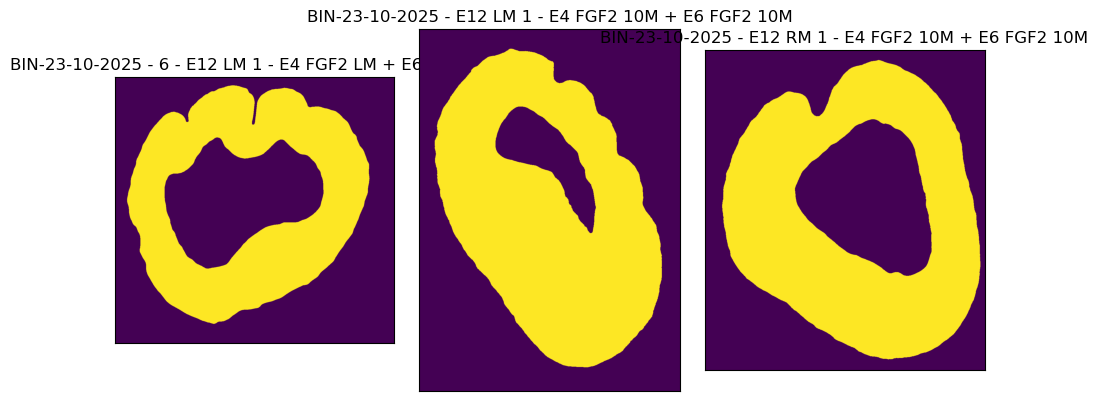

In [ ]:
fig, axs = plt.subplots(1, n, figsize = (3*n,4))

for i, name in enumerate(names):

    donut, res = get_picture2D(f'{folder}/{name}.tif')

    axs[i].set_title(name)
    axs[i].imshow(donut)



for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()


In [ ]:
df = pd.DataFrame()

for name in names:
    print(name)

    donut, res = get_picture2D(f'{folder}/{name}.tif')
    ref_points, _ = get_picture2D(f'{folder}/{name}_points.tif')

    current_df = thick_analysis(donut, ref_points, res)
    current_df['brain'] = name

    if len(df) == 0:
        df = current_df
    else:
        df = pd.concat([df, current_df])


BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E6 FGF2 LM
smoothing factor = 14.36


100%|██████████| 2871/2871 [01:00<00:00, 47.08it/s]


(1128, 1189)
BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 FGF2 10M
smoothing factor = 13.63


100%|██████████| 2453/2453 [00:41<00:00, 58.72it/s]


(1186, 859)
BIN-23-10-2025 - E12 RM 1 - E4 FGF2 10M + E6 FGF2 10M
smoothing factor = 14.39


100%|██████████| 2844/2844 [00:51<00:00, 55.54it/s]


(1128, 990)


<Axes: xlabel='norm', ylabel='dist'>

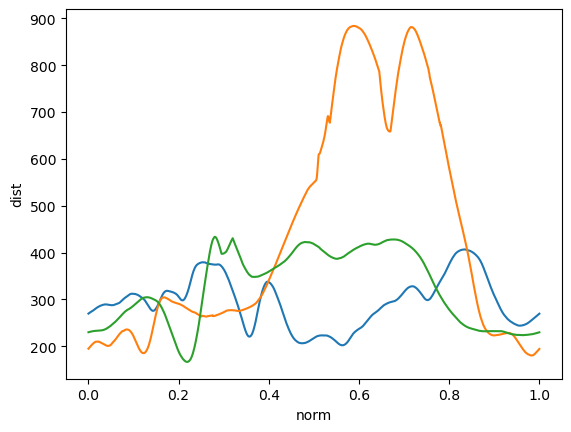

In [34]:
sns.lineplot(data=df, x='norm', y='dist', hue='brain', legend=False)